In [1]:
from __future__ import division, print_function, absolute_import

seed_num = 45

import numpy as np
np.random.seed(seed_num)
import random
random.seed(seed_num)
import tensorflow as tf
tf.set_random_seed(seed_num)

import os
import shutil
import sys
import glob
import math
from functools import reduce
import itertools
import operator as op
from sklearn.utils import class_weight
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn

dataset_folder = os.path.abspath("./individual_npzs_logmel/{0}/*.npz")
checkpoint_folder = "acrnn_topology1_es25"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

np.set_printoptions(suppress=True)

## Parameters

In [2]:
learning_rate = 0.00001
batch_size = 50
dropout = 0.1
recurrent_dropout = 0.9
final_dropout = 0.5
max_pool = 2
strides = 1
input_size = 60000
output_size = 4
epochs = 500
timesteps = 75

first_maps = 24
second_maps = 32
third_maps = 48

first_kernel = [5, 10, 1, first_maps]
second_kernel = [5, 10, first_maps, second_maps]
third_kernel = [3, 5, second_maps, third_maps]

hidden_layer = 128
dense_layer = 64

early_stop = 25

label_dictionary = {'ang': 0, 'hap': 1, 'neu': 2, 'sad': 3}
onehot_dictionary = {0: 'ang', 1: 'hap', 2:'neu', 3:'sad'}

## Helper methods

In [3]:
def batch_generator(data, labels):
    steps = math.ceil(data.shape[0] / batch_size)
    for batch_step in range(0, steps):
        start = batch_size * batch_step
        end = batch_size * (batch_step + 1)
        yield data[start:end], labels[start:end], batch_step

def compute_class_weights(labels):
    return np.ndarray.tolist(class_weight.compute_class_weight('balanced', np.unique(labels), labels))        

def build_encoded_array(emotion_label):
    initialized_array = [0. for key in label_dictionary]
    initialized_array[label_dictionary[emotion_label]] = 1.
    return initialized_array
        
def onehot_encode(label_minibatch):
    return [build_encoded_array(emotion_label) for emotion_label in label_minibatch]

def onehot_decode(onehot_labels):
    return [onehot_dictionary[label.index(1.0)] for label in onehot_labels]

def weighted_accuracy(y_pred, y_true):
    correct = 0
    all = 0
    for key in y_true:
        correct += y_pred[key]
        all += y_true[key]

    return correct/all


def unweighted_accuracy(y_pred, y_true):
    correct = 0
    emotions = len(y_true)
    for key in y_true:
        correct += y_pred[key]/y_true[key]

    return correct/emotions

def validation_results(current_sess, data, labels):
    predictions = current_sess.run(correct_prediction, feed_dict={X:data, Y:labels, keep_prob:1.0, normalization_switch: False})
    coupled_validation = list(zip(predictions, onehot_decode(labels)))
    final_dict = {'ang':0, 'hap':0, 'neu':0, 'sad':0}
    overall_dict = {'ang':0, 'hap':0, 'neu':0, 'sad':0}

    for couple in coupled_validation:
        if (couple[0]):
            final_dict[couple[1]] += 1
        overall_dict[couple[1]] += 1
    unweighted_acc = unweighted_accuracy(final_dict, overall_dict)
    return unweighted_acc

def compute_mean_std(data):
    dataset = []
    for key in data:
        dataset.extend(data[key]['M'][0])
        dataset.extend(data[key]['F'][0])
    
    dataset = np.asarray(dataset)
    data_to_norm = np.zeros([len(dataset), dataset[0].shape[0], dataset[0].shape[1]], dtype=np.float32)
    for spect_data in range(len(dataset)):
        data_to_norm[spect_data,:,:] = dataset[spect_data]
        
    dataset_mean = np.ndarray.astype(np.mean(data_to_norm, axis=(0,1,2), dtype='float64', keepdims=True), dtype='float32')
    dataset_std = np.ndarray.astype(np.std(data_to_norm, axis=(0,1,2), dtype='float64', keepdims=True), dtype='float32')

    return dataset_mean, dataset_std

def compute_mean_std_train(data, skip):
    dataset = []
    for key in data:
        if key != skip:
            dataset.extend(data[key]['M'][0])
            dataset.extend(data[key]['F'][0])
    
    dataset = np.asarray(dataset)
    data_to_norm = np.zeros([len(dataset), dataset[0].shape[0], dataset[0].shape[1]], dtype=np.float32)
    for spect_data in range(len(dataset)):
        data_to_norm[spect_data,:,:] = dataset[spect_data]
        
    dataset_mean = np.ndarray.astype(np.mean(data_to_norm, axis=(0,1,2), dtype='float64', keepdims=True), dtype='float32')
    dataset_std = np.ndarray.astype(np.std(data_to_norm, axis=(0,1,2), dtype='float64', keepdims=True), dtype='float32')

    return dataset_mean, dataset_std

## Load dataset: 4 sessions for training, 1 for test

In [4]:
def prepare_train_data(data, to_skip, mean, std):
    
    # load for train except validation and train session
    train_dataset = []
    train_labels = []
    for key in data:
        if key != to_skip:
            train_dataset.extend(data[key]['M'][0])
            train_dataset.extend(data[key]['F'][0])
            train_labels.extend(data[key]['M'][1])
            train_labels.extend(data[key]['F'][1])
    
    # transform to desired shapes
    train_dataset = np.asarray(train_dataset)
    train_data = np.zeros([len(train_dataset), train_dataset[0].shape[0], train_dataset[0].shape[1]], dtype=np.float32)
    for spect_data in range(len(train_dataset)):
        train_data[spect_data,:,:] = train_dataset[spect_data]
    
    other_dataset = np.concatenate((np.asarray(data[to_skip]['M'][0]), np.asarray(data[to_skip]['F'][0])))
    other_labs = np.concatenate((np.asarray(data[to_skip]['M'][1]), np.asarray(data[to_skip]['F'][1])))
    other_data = np.zeros([len(other_dataset), other_dataset[0].shape[0], other_dataset[0].shape[1]], dtype=np.float32)
    for spect_data in range(len(other_dataset)):
        other_data[spect_data,:,:] = other_dataset[spect_data]
        
    # z-norm the dataset
    train_data = (train_data - mean) / std
        
    # shuffle the dataset
    train_data, train_labels = shuffle(train_data, train_labels, random_state=seed_num)
    train_data = train_data.reshape((train_data.shape[0], input_size))

    # compute class_weights and onehot encode after
    class_weights = compute_class_weights(train_labels)
    train_labels = onehot_encode(train_labels)
    
    return train_data, train_labels, class_weights

In [5]:
def prepare_validation_test_sets(data, gender, test_val_session, mean, std):
    
    test_dataset = data[test_val_session][gender][0]
    test_labels = data[test_val_session][gender][1]
    
    validation_dataset = []
    validation_labels = []
    
    if gender == 'M':
        validation_dataset = data[test_val_session]['F'][0]
        validation_labels = data[test_val_session]['F'][1]
    else:
        validation_dataset = data[test_val_session]['M'][0]
        validation_labels = data[test_val_session]['M'][1]
    
    # transform to desired shapes
    test_dataset = np.asarray(test_dataset)
    test_data = np.zeros([len(test_dataset), test_dataset[0].shape[0], test_dataset[0].shape[1]], dtype=np.float32)
    for spect_data in range(len(test_dataset)):
        test_data[spect_data,:,:] = test_dataset[spect_data]
    
    validation_dataset = np.asarray(validation_dataset)
    validation_data = np.zeros([len(validation_dataset), validation_dataset[0].shape[0], validation_dataset[0].shape[1]], dtype=np.float32)
    for spect_data in range(len(validation_dataset)):
        validation_data[spect_data,:,:] = validation_dataset[spect_data]
        
    # z-norm the dataset
    validation_data = (validation_data - mean) / std
    test_data = (test_data - mean) / std

    test_data = test_data.reshape((test_data.shape[0], input_size))
    validation_data = validation_data.reshape((validation_data.shape[0], input_size))

    # onehot encode labels
    test_labels = onehot_encode(test_labels)
    validation_labels = onehot_encode(validation_labels)
    
    return test_data, test_labels, validation_data, validation_labels

## Pipeline

In [6]:
def conv2d(to_process, weights, biases, batchnorm_switch, strides=1):
    conv_out = tf.nn.conv2d(to_process, weights, strides=[1, strides, strides, 1], padding='SAME')
    bias_out = tf.nn.bias_add(conv_out, biases)
    batchnorm_out = tf.layers.batch_normalization(bias_out, training=batchnorm_switch)
    relu_out = tf.nn.leaky_relu(batchnorm_out, 0.01)
    return relu_out

def maxpool2d(to_pool, pool_size=2):
    maxpool_out = tf.nn.max_pool(to_pool, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='SAME')
    return maxpool_out

def attention(rnn_inputs, attention_size):

    hidden_size = rnn_inputs.shape[2].value

    fully_connected_weights = tf.Variable(tf.random_normal([hidden_size, attention_size], stddev=0.1))
    fully_connected_bias = tf.Variable(tf.random_normal([attention_size], stddev=0.1))
    context_vector = tf.Variable(tf.random_normal([attention_size], stddev=0.1))

    hidden_representation = tf.sigmoid(tf.tensordot(rnn_inputs, fully_connected_weights, axes=1) + fully_connected_bias)
    weights = tf.tensordot(hidden_representation, context_vector, axes=1) 
    normalized_weights = tf.nn.softmax(weights)          

    summary_vector = tf.reduce_sum(rnn_inputs * tf.expand_dims(normalized_weights, -1), 1)
    
    return summary_vector
   
def nn_pipeline_rnn(spectrogram, weights, biases, dropout_num, rnn_dropout, fully_connected_dropout, training_switch):
    reshaped_input = tf.reshape(spectrogram, shape=[-1, 200, 300, 1])

    first_layer_out = conv2d(reshaped_input, weights['first_layer_weights'], biases['first_layer_biases'], normalization_switch)
    first_drop_out = tf.layers.dropout(first_layer_out, dropout_num, seed=seed_num+256, training=training_switch)
    first_maxpool_out = maxpool2d(first_drop_out, pool_size=2)

    second_layer_out = conv2d(first_maxpool_out, weights['second_layer_weights'], biases['second_layer_biases'], normalization_switch)
    second_drop_out = tf.layers.dropout(second_layer_out, dropout_num, seed=seed_num+128, training=training_switch)
    second_maxpool_out = maxpool2d(second_drop_out, pool_size=2)

    third_layer_out = conv2d(second_maxpool_out, weights['third_layer_weights'], biases['third_layer_biases'], normalization_switch)
    third_drop_out = tf.layers.dropout(third_layer_out, dropout_num, seed=seed_num+1024, training=training_switch)
    
    interim_shape = third_drop_out.get_shape().as_list()
    transposed = tf.transpose(third_drop_out, perm=[0, 2, 1, 3])
    reshape_for_rnn = tf.reshape(transposed, [-1, interim_shape[2], interim_shape[1]*interim_shape[3]])
    reshape_for_rnn.set_shape([None, interim_shape[2], interim_shape[1]*interim_shape[3]])
    
    fw_cell = tf.contrib.rnn.GRUCell(hidden_layer)
    bw_cell = tf.contrib.rnn.GRUCell(hidden_layer)
    gru_fw_cell = tf.contrib.rnn.DropoutWrapper(cell=fw_cell, output_keep_prob=rnn_dropout, seed=(seed_num+32))
    gru_bw_cell = tf.contrib.rnn.DropoutWrapper(cell=bw_cell, output_keep_prob=rnn_dropout, seed=(seed_num+64))
    
    gru_output, _ = tf.nn.bidirectional_dynamic_rnn(gru_fw_cell, gru_bw_cell, reshape_for_rnn, dtype=tf.float32)
    gru_output_concatted = tf.concat(gru_output, axis=2)
    
    attention_out = attention(gru_output_concatted, 1)
    
    fully_connected_out = tf.add(tf.matmul(attention_out, weights['gru_weights']), biases['gru_biases'])
    fully_connected_activation = tf.nn.leaky_relu(fully_connected_out, 0.01)
    
    prediction = tf.add(tf.matmul(fully_connected_activation, weights['output']), biases['output'])
        
    return prediction

In [7]:
def validate_network(session, val_data, val_labels, epoch_step, test_num, test_gender):

    val_generator = batch_generator(val_data, val_labels)
    acc_val_all = []
    loss_val_all = []
    predictions_all = np.asarray([])
    for minibatch, labels, current_index in val_generator:
        loss, acc = sess.run([loss_function, accuracy], feed_dict={X: minibatch, Y: labels, keep_prob: 1.0, keep_rnn_prob: 1.0, keep_fully_prob: 1.0, normalization_switch: False})
        predics = sess.run(tf.argmax(prediction, 1), feed_dict={X: minibatch, Y: labels, keep_prob: 1.0, keep_rnn_prob: 1.0, keep_fully_prob: 1.0, normalization_switch: False})
        predictions_all = np.concatenate((predictions_all, predics))
        acc_val_all.append(acc)
        loss_val_all.append(loss)
    val_acc = np.mean(acc_val_all)
    val_loss = np.mean(loss_val_all)
    validation_confusion = confusion_matrix(predictions_all, [onehot.index(1.0) for onehot in validation_labels])
    validation_recall = np.mean(np.diag(validation_confusion) / np.sum(validation_confusion, axis=1))
    validation_unweighted = np.mean(np.diag(validation_confusion) / np.sum(validation_confusion, axis=0))
    
    print("Validation after epoch #" + str(epoch_step) + ", Validation Loss= "+ "{:.4f}".format(val_loss) + ", Validation Accuracy= " + "{:.3f}".format(val_acc) + ", Unweighted Accuracy= " + "{:.3f}".format(validation_unweighted) + ", Recall= " + " {:.3f}".format(validation_recall))
    print(validation_confusion)

    acc_loss_file_validation = open(checkpoint_folder + "val_loss_logs_session{0}_{1}.txt".format(test_num, test_gender), "a+")
    acc_loss_file_validation.write("{0}, {1}, {2}, {3}, {4}\n".format(epoch_step, val_acc, val_loss, validation_unweighted, validation_recall))
    acc_loss_file_validation.close()
    return val_loss, val_acc, validation_unweighted

In [8]:
def train_network(session, tr_data, tr_labels, val_data, val_labels, test_num, test_gender):
    
    best_acc = 0
    best_loss = sys.maxsize
    best_train_acc = 0
    current_tolerance = 0
    best_val_acc = 0
    tolerance = 0
    best_val_loss = sys.maxsize
    best_val_unweighted = 0
    
    for epoch_step in range(1, epochs+1):
        batch_gen = batch_generator(tr_data, tr_labels)
        train_acc_all = []
        train_loss_all = []
        for data_minibatch, label_minibatch, current_index in batch_gen:
            session.run(train_trigger, feed_dict={X: data_minibatch, Y: label_minibatch, keep_prob: dropout, keep_rnn_prob: recurrent_dropout, keep_fully_prob:final_dropout, normalization_switch: True})
            train_loss, train_acc = session.run([loss_function, accuracy], feed_dict={X: data_minibatch, Y: label_minibatch, keep_prob: 1.0, keep_rnn_prob: 1.0, keep_fully_prob: 1.0, normalization_switch: False})
            train_acc_all.append(train_acc)
            train_loss_all.append(train_loss)
        train_acc_whole = np.mean(train_acc_all)
        train_loss_whole = np.mean(train_loss_all)
        acc_loss_file = open(checkpoint_folder + "train_loss_logs_session{0}_{1}.txt".format(test_num,test_gender), "a+")
        acc_loss_file.write("{0}, {1}, {2}\n".format(epoch_step, train_acc_whole, train_loss_whole))
        acc_loss_file.close()
        print("\nTraining accuracy and loss of epoch #" + str(epoch_step) + ": {:.4f}".format(train_acc_whole) + ", {:.4f}".format(train_loss_whole))
        
        val_loss, val_acc, val_unweighted = validate_network(session, val_data, val_labels, epoch_step, test_num, test_gender)
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            saver.save(sess, checkpoint_folder + "loss_session{0}_{1}/best_model_loss.ckpt".format(test_num, test_gender))
            print("Saved model by validation loss {0}".format(val_loss))
            if tolerance != 0:
                tolerance -= 1

        if best_val_unweighted < val_unweighted:
            best_val_unweighted = val_unweighted
            saver.save(sess, checkpoint_folder + "uacc_session{0}_{1}/best_model_uacc.ckpt".format(test_num, test_gender))
            print("Saved model by validation unweighted acc {0}".format(val_unweighted))
            tolerance = 0
        else:
            tolerance += 1
        
        if tolerance >= early_stop:
            break


    print("Optimization Finished!")

In [9]:
def test_sentence(sess, npz_file, mean, std):
    correct_label = npz_file['labels'][0]
    final_prediction = []
    prediction_add = [0, 0, 0, 0]
    amount = 0
    for spectrogram in npz_file['spectrograms']:
        amount += 1
        to_test = np.asarray(spectrogram)
        to_test = (to_test - mean) / std
        to_test = to_test.reshape(1, 60000)
        
        predic = sess.run(prediction, feed_dict={X: to_test, Y: onehot_encode([correct_label]), keep_prob: 1.0, keep_rnn_prob: 1.0, keep_fully_prob: 1.0, normalization_switch: False})
        prediction_add = prediction_add + predic
    prediction_add = prediction_add[0].tolist()
    prediction_add = [pred/amount for pred in prediction_add]
    final_prediction = prediction_add.index(max(prediction_add))
    encoded = onehot_encode([correct_label])
    correct_pred = encoded[0].index(1.0)
    return final_prediction, correct_pred

In [10]:
def evaluate_model(session, session_number, session_gender):
    predicted_labels = []
    correct_labels = []
    sentence_amount = 0

    for spectrogram in glob.glob(dataset_folder.format("session{0}".format(session_number))):
        gender = spectrogram.split('\\')[-1].split('_')[2][0]
        if gender == session_gender:
            sentence = np.load(spectrogram)
            final, correct = test_sentence(sess, sentence, dmean, dstd)
            predicted_labels.append(final)
            correct_labels.append(correct)
            sentence_amount += 1
    matrix = confusion_matrix(predicted_labels, correct_labels)
    test_recall = np.mean(np.diag(matrix) / np.sum(matrix, axis=1))
    test_unweighted = np.mean(np.diag(matrix) / np.sum(matrix, axis=0))
    acc = np.sum(np.diag(matrix)) / sentence_amount
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100
    print("Acc: {0}, UAcc: {1}, Recall: {2}".format(acc, test_unweighted, test_recall))
    print(matrix)
    test_log_file = open(checkpoint_folder + "test_logs_session{0}_{1}.txt".format(session_number, session_gender), "a+")
    test_log_file.write("{0}, {1}, {2}\n".format(acc, test_unweighted, test_recall))
    test_log_file.write("{0}\n".format(matrix))
    test_log_file.close()


In [11]:
def evaluate_model_results(session, session_number, session_gender):
    predicted_labels = []
    correct_labels = []
    sentence_amount = 0

    for spectrogram in glob.glob(dataset_folder.format("session{0}".format(session_number))):
        gender = spectrogram.split('\\')[-1].split('_')[2][0]
        if gender == session_gender:
            sentence = np.load(spectrogram)
            final, correct = test_sentence(sess, sentence, dmean, dstd)
            predicted_labels.append(final)
            correct_labels.append(correct)
            sentence_amount += 1
    matrix = confusion_matrix(predicted_labels, correct_labels)
    test_recall = np.mean(np.diag(matrix) / np.sum(matrix, axis=1))
    test_unweighted = np.mean(np.diag(matrix) / np.sum(matrix, axis=0))
    acc = np.sum(np.diag(matrix)) / sentence_amount
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100
    print("Acc: {0}, UAcc: {1}, Recall: {2}".format(acc, test_unweighted, test_recall))
    print(matrix)
    
    return acc, test_unweighted, test_recall, matrix
    

In [12]:
all_speakers = {1: {'M': (), 'F': ()},
               2: {'M': (), 'F': ()},
               3: {'M': (), 'F': ()},
               4: {'M': (), 'F': ()},
               5: {'M': (), 'F': ()}}

session_string = 'session{0}'

for i in range(1, 6):
    male_spect = []
    female_spect = []
    male_labels = []
    female_labels = []
    formatted = session_string.format(i)
    for spectrogram in glob.glob(dataset_folder.format(formatted)):
        loaded_spec = np.load(spectrogram)
        gender = spectrogram.split('\\')[-1].split('_')[2][0]
        for spect in loaded_spec['spectrograms']:
            if gender == 'M':
                male_spect.append(spect)
            else:
                female_spect.append(spect)
        for label in loaded_spec['labels']:
            if gender == 'M':
                male_labels.append(label)
            else:
                female_labels.append(label)
    all_speakers[i] = {'M': (male_spect, male_labels), 'F': (female_spect, female_labels)}

dmean, dstd = compute_mean_std(all_speakers)

In [13]:
for key in all_speakers:
    train_data, train_labels, class_weights = prepare_train_data(all_speakers, key, dmean, dstd)
    for subkey in all_speakers[key]:

        X = tf.placeholder(tf.float32, [None, input_size])
        Y = tf.placeholder(tf.float32, [None, output_size])

        weights_rnn = {
            'first_layer_weights': tf.Variable(tf.truncated_normal(first_kernel, stddev=0.1, seed=seed_num)),
            'second_layer_weights': tf.Variable(tf.truncated_normal(second_kernel, stddev=0.1, seed=(seed_num+4))),
            'third_layer_weights': tf.Variable(tf.truncated_normal(third_kernel, stddev=0.1,seed=(seed_num+8))),
            'gru_weights': tf.Variable(tf.truncated_normal([2*hidden_layer, dense_layer], stddev=0.1, seed=(seed_num+2))),
            'output': tf.Variable(tf.truncated_normal([dense_layer, output_size], stddev=0.1, seed=(seed_num+16)))
        }

        biases_rnn = {
            'first_layer_biases': tf.get_variable('first_bias', [first_maps], initializer=tf.constant_initializer(0.1)),
            'second_layer_biases': tf.get_variable('second_bias', [second_maps], initializer=tf.constant_initializer(0.1)),
            'third_layer_biases': tf.get_variable('third_bias', [third_maps], initializer=tf.constant_initializer(0.1)),
            'gru_biases': tf.get_variable('gru_bias', [dense_layer], initializer=tf.constant_initializer(0.1)),
            'output': tf.get_variable('output_bias', [output_size], initializer=tf.constant_initializer(0.1))
        }

        keep_prob = tf.placeholder(tf.float32)
        keep_rnn_prob = tf.placeholder(tf.float32)
        keep_fully_prob = tf.placeholder(tf.float32)
        normalization_switch = tf.placeholder(tf.bool)

        logits = nn_pipeline_rnn(X, weights_rnn, biases_rnn, keep_prob, keep_rnn_prob, keep_fully_prob, normalization_switch)
        prediction = tf.nn.softmax(logits)
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        weights = tf.reduce_sum(class_weights * Y, axis=1)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y)
        weighted_entropy = cross_entropy * weights
        loss_function = tf.reduce_mean(weighted_entropy)
        cross = tf.reduce_mean(cross_entropy)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            train_trigger = optimizer.minimize(loss_function)


        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        test_data, test_labels, validation_data, validation_labels = prepare_validation_test_sets(all_speakers, subkey, key, dmean, dstd)

        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)
        sess.run(init)

        print('Session initialized with session {0} and test speaker {1}.'.format(key, subkey))
        train_network(sess, train_data, train_labels, validation_data, validation_labels, key, subkey)

        saver.restore(sess, checkpoint_folder + "uacc_session{0}_{1}/best_model_uacc.ckpt".format(key, subkey))    

        evaluate_model(sess, key, subkey)
        tf.reset_default_graph()


Session initialized with session 1 and test speaker M.

Training accuracy and loss of epoch #1: 0.1505, 1.3855
Validation after epoch #1, Validation Loss= 1.3138, Validation Accuracy= 0.200, Unweighted Accuracy= 0.326, Recall=  0.375
[[59 19 84 43]
 [10 12 89 59]
 [ 0  0  3  4]
 [ 0  0  2  5]]
Saved model by validation loss 1.313765525817871
Saved model by validation unweighted acc 0.3260170538977447

Training accuracy and loss of epoch #2: 0.2009, 1.3252
Validation after epoch #2, Validation Loss= 1.2753, Validation Accuracy= 0.316, Unweighted Accuracy= 0.450, Recall=  0.393
[[58 15 71 32]
 [11 16 49 30]
 [ 0  0  5  3]
 [ 0  0 53 46]]
Saved model by validation loss 1.2753379344940186
Saved model by validation unweighted acc 0.44980326111446395

Training accuracy and loss of epoch #3: 0.3112, 1.2821
Validation after epoch #3, Validation Loss= 1.2334, Validation Accuracy= 0.400, Unweighted Accuracy= 0.508, Recall=  0.438
[[59 15 61 22]
 [ 9 14 33 13]
 [ 1  2 14  4]
 [ 0  0 70 72]]
Saved

Saved model by validation loss 1.0013781785964966

Training accuracy and loss of epoch #27: 0.6543, 0.8511
Validation after epoch #27, Validation Loss= 0.9992, Validation Accuracy= 0.509, Unweighted Accuracy= 0.528, Recall=  0.481
[[51  9 18  3]
 [ 6  8 19  4]
 [12 13 49 11]
 [ 0  1 92 93]]
Saved model by validation loss 0.9991785287857056

Training accuracy and loss of epoch #28: 0.6568, 0.8440
Validation after epoch #28, Validation Loss= 0.9964, Validation Accuracy= 0.511, Unweighted Accuracy= 0.529, Recall=  0.481
[[51  9 18  3]
 [ 6  8 19  4]
 [12 14 50 11]
 [ 0  0 91 93]]
Saved model by validation loss 0.9964408874511719

Training accuracy and loss of epoch #29: 0.6582, 0.8371
Validation after epoch #29, Validation Loss= 0.9927, Validation Accuracy= 0.516, Unweighted Accuracy= 0.538, Recall=  0.492
[[51  9 17  3]
 [ 7  9 19  4]
 [11 13 51 11]
 [ 0  0 91 93]]
Saved model by validation loss 0.9926553964614868

Training accuracy and loss of epoch #30: 0.6603, 0.8303
Validation after 

Validation after epoch #54, Validation Loss= 0.9536, Validation Accuracy= 0.536, Unweighted Accuracy= 0.552, Recall=  0.505
[[53  9 18  2]
 [ 3  9 19  7]
 [13 13 60 12]
 [ 0  0 81 90]]
Saved model by validation loss 0.9535972476005554

Training accuracy and loss of epoch #55: 0.7088, 0.6836
Validation after epoch #55, Validation Loss= 0.9535, Validation Accuracy= 0.539, Unweighted Accuracy= 0.553, Recall=  0.508
[[53  9 18  2]
 [ 3  9 18  6]
 [13 13 61 13]
 [ 0  0 81 90]]
Saved model by validation loss 0.9534632563591003

Training accuracy and loss of epoch #56: 0.7127, 0.6779
Validation after epoch #56, Validation Loss= 0.9525, Validation Accuracy= 0.536, Unweighted Accuracy= 0.552, Recall=  0.506
[[53  9 18  2]
 [ 3  9 19  6]
 [13 12 60 13]
 [ 0  1 81 90]]
Saved model by validation loss 0.9525173902511597

Training accuracy and loss of epoch #57: 0.7146, 0.6720
Validation after epoch #57, Validation Loss= 0.9509, Validation Accuracy= 0.538, Unweighted Accuracy= 0.551, Recall=  0.508



Training accuracy and loss of epoch #86: 0.8034, 0.4819
Validation after epoch #86, Validation Loss= 0.9653, Validation Accuracy= 0.545, Unweighted Accuracy= 0.559, Recall=  0.523
[[49  7 15  1]
 [ 3 11 18  8]
 [17 12 67 14]
 [ 0  1 78 88]]

Training accuracy and loss of epoch #87: 0.8058, 0.4737
Validation after epoch #87, Validation Loss= 0.9664, Validation Accuracy= 0.543, Unweighted Accuracy= 0.555, Recall=  0.520
[[49  7 15  1]
 [ 3 11 18 10]
 [17 12 68 14]
 [ 0  1 77 86]]

Training accuracy and loss of epoch #88: 0.8077, 0.4665
Validation after epoch #88, Validation Loss= 0.9655, Validation Accuracy= 0.546, Unweighted Accuracy= 0.557, Recall=  0.522
[[49  7 15  1]
 [ 3 11 18  9]
 [17 12 69 15]
 [ 0  1 76 86]]

Training accuracy and loss of epoch #89: 0.8121, 0.4593
Validation after epoch #89, Validation Loss= 0.9677, Validation Accuracy= 0.543, Unweighted Accuracy= 0.555, Recall=  0.520
[[49  7 15  1]
 [ 3 11 18  9]
 [17 12 68 15]
 [ 0  1 77 86]]

Training accuracy and loss of e

Saved model by validation loss 1.0405036211013794
Saved model by validation unweighted acc 0.5230245286806372

Training accuracy and loss of epoch #10: 0.5836, 1.0174
Validation after epoch #10, Validation Loss= 1.0246, Validation Accuracy= 0.578, Unweighted Accuracy= 0.523, Recall=  0.490
[[ 33   7  17   4]
 [  4   1   5   0]
 [ 13  16  79   3]
 [  1   3  68 112]]
Saved model by validation loss 1.0246436595916748
Saved model by validation unweighted acc 0.5231819881141149

Training accuracy and loss of epoch #11: 0.5874, 0.9996
Validation after epoch #11, Validation Loss= 1.0119, Validation Accuracy= 0.576, Unweighted Accuracy= 0.514, Recall=  0.464
[[ 33   7  16   4]
 [  3   0   5   0]
 [ 14  17  79   3]
 [  1   3  69 112]]
Saved model by validation loss 1.0119162797927856

Training accuracy and loss of epoch #12: 0.5921, 0.9849
Validation after epoch #12, Validation Loss= 0.9983, Validation Accuracy= 0.583, Unweighted Accuracy= 0.526, Recall=  0.498
[[ 33   6  15   4]
 [  3   1   5 

Saved model by validation loss 0.8256354331970215

Training accuracy and loss of epoch #34: 0.6621, 0.8129
Validation after epoch #34, Validation Loss= 0.8212, Validation Accuracy= 0.662, Unweighted Accuracy= 0.627, Recall=  0.594
[[ 42   4  15   4]
 [  2   5  13   0]
 [  7  17  96   4]
 [  0   1  45 111]]
Saved model by validation loss 0.821199893951416
Saved model by validation unweighted acc 0.6273837608679238

Training accuracy and loss of epoch #35: 0.6629, 0.8072
Validation after epoch #35, Validation Loss= 0.8169, Validation Accuracy= 0.662, Unweighted Accuracy= 0.627, Recall=  0.594
[[ 42   4  15   4]
 [  2   5  13   0]
 [  7  17  96   4]
 [  0   1  45 111]]
Saved model by validation loss 0.8169244527816772

Training accuracy and loss of epoch #36: 0.6627, 0.8011
Validation after epoch #36, Validation Loss= 0.8123, Validation Accuracy= 0.662, Unweighted Accuracy= 0.635, Recall=  0.606
[[ 42   4  16   4]
 [  1   6  12   0]
 [  8  16  96   5]
 [  0   1  45 110]]
Saved model by va


Training accuracy and loss of epoch #60: 0.7100, 0.6656
Validation after epoch #60, Validation Loss= 0.7608, Validation Accuracy= 0.677, Unweighted Accuracy= 0.656, Recall=  0.625
[[ 43   5  16   4]
 [  3   8  11   0]
 [  5  13 102  10]
 [  0   1  40 105]]
Saved model by validation loss 0.7607967853546143

Training accuracy and loss of epoch #61: 0.7119, 0.6594
Validation after epoch #61, Validation Loss= 0.7576, Validation Accuracy= 0.679, Unweighted Accuracy= 0.659, Recall=  0.626
[[ 43   5  17   4]
 [  3   8  11   0]
 [  5  13 101   8]
 [  0   1  40 107]]
Saved model by validation loss 0.7576488256454468

Training accuracy and loss of epoch #62: 0.7141, 0.6529
Validation after epoch #62, Validation Loss= 0.7578, Validation Accuracy= 0.677, Unweighted Accuracy= 0.656, Recall=  0.625
[[ 43   5  16   4]
 [  3   8  11   0]
 [  5  13 102  10]
 [  0   1  40 105]]

Training accuracy and loss of epoch #63: 0.7186, 0.6469
Validation after epoch #63, Validation Loss= 0.7571, Validation Accur


Training accuracy and loss of epoch #90: 0.8007, 0.4634
Validation after epoch #90, Validation Loss= 0.7950, Validation Accuracy= 0.677, Unweighted Accuracy= 0.666, Recall=  0.630
[[ 44   6  15   3]
 [  2   9  12   1]
 [  5  11 103  13]
 [  0   1  39 102]]

Training accuracy and loss of epoch #91: 0.8092, 0.4547
Validation after epoch #91, Validation Loss= 0.7918, Validation Accuracy= 0.682, Unweighted Accuracy= 0.677, Recall=  0.640
[[ 44   6  15   3]
 [  2  10  12   1]
 [  5  10 103  12]
 [  0   1  39 103]]

Training accuracy and loss of epoch #92: 0.8127, 0.4463
Validation after epoch #92, Validation Loss= 0.8000, Validation Accuracy= 0.679, Unweighted Accuracy= 0.675, Recall=  0.638
[[ 44   6  15   3]
 [  2  10  12   1]
 [  5  10 103  13]
 [  0   1  39 102]]

Training accuracy and loss of epoch #93: 0.8141, 0.4388
Validation after epoch #93, Validation Loss= 0.8101, Validation Accuracy= 0.677, Unweighted Accuracy= 0.666, Recall=  0.630
[[ 44   6  15   3]
 [  2   9  12   1]
 [  5  

c:\users\marcelk\pycharmprojects\bcmarcel\venv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Validation after epoch #1, Validation Loss= 1.2604, Validation Accuracy= 0.347, Unweighted Accuracy= 0.390, Recall=  nan
[[ 16  27  79  43]
 [  0   0   0   0]
 [  1  18 115  71]
 [  0   0   0   3]]
Saved model by validation loss 1.260357141494751
Saved model by validation unweighted acc 0.389900250345975

Training accuracy and loss of epoch #2: 0.3151, 1.3414
Validation after epoch #2, Validation Loss= 1.2593, Validation Accuracy= 0.280, Unweighted Accuracy= 0.386, Recall=  nan
[[ 17  32 117  54]
 [  0   0   0   0]
 [  0  13  77  46]
 [  0   0   0  17]]
Saved model by validation loss 1.2593095302581787

Training accuracy and loss of epoch #3: 0.3714, 1.3153
Validation after epoch #3, Validation Loss= 1.2343, Validation Accuracy= 0.357, Unweighted Accuracy= 0.404, Recall=  nan
[[ 16  27  86  43]
 [  0   0   0   0]
 [  1  18 108  60]
 [  0   0   0  14]]
Saved model by validation loss 1.2342830896377563
Saved model by validation unweighted acc 0.4043839052935475

Training accuracy and los

Saved model by validation loss 0.9914175868034363
Saved model by validation unweighted acc 0.5951581637148647

Training accuracy and loss of epoch #25: 0.6146, 0.9006
Validation after epoch #25, Validation Loss= 0.9879, Validation Accuracy= 0.523, Unweighted Accuracy= 0.600, Recall=  0.537
[[ 17  17  62  15]
 [  0  14  18   5]
 [  0  13 110  36]
 [  0   1   4  61]]
Saved model by validation loss 0.9879096746444702
Saved model by validation unweighted acc 0.5998722354392457

Training accuracy and loss of epoch #26: 0.6169, 0.8958
Validation after epoch #26, Validation Loss= 0.9855, Validation Accuracy= 0.523, Unweighted Accuracy= 0.600, Recall=  0.537
[[ 17  17  62  15]
 [  0  14  18   5]
 [  0  13 110  36]
 [  0   1   4  61]]
Saved model by validation loss 0.9855105876922607

Training accuracy and loss of epoch #27: 0.6205, 0.8910
Validation after epoch #27, Validation Loss= 0.9829, Validation Accuracy= 0.520, Unweighted Accuracy= 0.596, Recall=  0.539
[[ 17  17  62  15]
 [  0  14  16 

Validation after epoch #50, Validation Loss= 0.9376, Validation Accuracy= 0.537, Unweighted Accuracy= 0.635, Recall=  0.551
[[ 17  14  55   8]
 [  0  21  22  10]
 [  0   9 114  42]
 [  0   1   3  57]]

Training accuracy and loss of epoch #51: 0.6672, 0.7709
Validation after epoch #51, Validation Loss= 0.9356, Validation Accuracy= 0.532, Unweighted Accuracy= 0.633, Recall=  0.545
[[ 17  14  55   8]
 [  0  21  24  12]
 [  0   9 112  40]
 [  0   1   3  57]]

Training accuracy and loss of epoch #52: 0.6680, 0.7654
Validation after epoch #52, Validation Loss= 0.9316, Validation Accuracy= 0.532, Unweighted Accuracy= 0.633, Recall=  0.545
[[ 17  14  55   8]
 [  0  21  24  12]
 [  0   9 112  40]
 [  0   1   3  57]]
Saved model by validation loss 0.9315581321716309

Training accuracy and loss of epoch #53: 0.6714, 0.7598
Validation after epoch #53, Validation Loss= 0.9302, Validation Accuracy= 0.525, Unweighted Accuracy= 0.629, Recall=  0.538
[[ 17  14  55   8]
 [  0  21  27  14]
 [  0   9 109 

Validation after epoch #77, Validation Loss= 0.9038, Validation Accuracy= 0.562, Unweighted Accuracy= 0.661, Recall=  0.559
[[ 17  13  48   6]
 [  0  23  26  20]
 [  0   8 117  29]
 [  0   1   3  62]]

Training accuracy and loss of epoch #78: 0.7300, 0.6120
Validation after epoch #78, Validation Loss= 0.8974, Validation Accuracy= 0.570, Unweighted Accuracy= 0.669, Recall=  0.564
[[ 17  12  46   6]
 [  0  24  26  20]
 [  0   8 119  29]
 [  0   1   3  62]]
Saved model by validation loss 0.897432804107666
Saved model by validation unweighted acc 0.6691624812758833

Training accuracy and loss of epoch #79: 0.7333, 0.6069
Validation after epoch #79, Validation Loss= 0.9006, Validation Accuracy= 0.570, Unweighted Accuracy= 0.665, Recall=  0.560
[[ 17  13  46   6]
 [  0  23  24  19]
 [  0   8 120  30]
 [  0   1   4  62]]

Training accuracy and loss of epoch #80: 0.7342, 0.6001
Validation after epoch #80, Validation Loss= 0.8990, Validation Accuracy= 0.568, Unweighted Accuracy= 0.667, Recall= 


Training accuracy and loss of epoch #108: 0.8102, 0.3964
Validation after epoch #108, Validation Loss= 1.0039, Validation Accuracy= 0.553, Unweighted Accuracy= 0.641, Recall=  0.542
[[ 17  12  46   6]
 [  0  20  32  20]
 [  0  12 113  28]
 [  0   1   3  63]]

Training accuracy and loss of epoch #109: 0.8125, 0.3898
Validation after epoch #109, Validation Loss= 1.0125, Validation Accuracy= 0.556, Unweighted Accuracy= 0.644, Recall=  0.541
[[ 17  12  46   8]
 [  0  20  32  18]
 [  0  12 112  26]
 [  0   1   4  65]]

Training accuracy and loss of epoch #110: 0.8144, 0.3803
Validation after epoch #110, Validation Loss= 1.0131, Validation Accuracy= 0.548, Unweighted Accuracy= 0.639, Recall=  0.539
[[ 17  12  46   6]
 [  0  20  34  20]
 [  0  12 111  28]
 [  0   1   3  63]]

Training accuracy and loss of epoch #111: 0.8167, 0.3739
Validation after epoch #111, Validation Loss= 1.0306, Validation Accuracy= 0.553, Unweighted Accuracy= 0.642, Recall=  0.538
[[ 17  11  47   8]
 [  0  20  31  17]

Saved model by validation unweighted acc 0.5224938695614765

Training accuracy and loss of epoch #21: 0.6294, 0.9233
Validation after epoch #21, Validation Loss= 0.8265, Validation Accuracy= 0.592, Unweighted Accuracy= 0.529, Recall=  0.488
[[  8   8  14   0]
 [ 21  28  73   1]
 [  5  20 162  17]
 [  0   0  44  87]]
Saved model by validation loss 0.8264636993408203
Saved model by validation unweighted acc 0.5291916425273181

Training accuracy and loss of epoch #22: 0.6270, 0.9179
Validation after epoch #22, Validation Loss= 0.8219, Validation Accuracy= 0.600, Unweighted Accuracy= 0.536, Recall=  0.497
[[  8   7  13   0]
 [ 21  29  72   1]
 [  5  20 165  17]
 [  0   0  43  87]]
Saved model by validation loss 0.8219002485275269
Saved model by validation unweighted acc 0.5362156552040612

Training accuracy and loss of epoch #23: 0.6291, 0.9130
Validation after epoch #23, Validation Loss= 0.8191, Validation Accuracy= 0.602, Unweighted Accuracy= 0.536, Recall=  0.495
[[  8   7  14   0]
 [ 2


Training accuracy and loss of epoch #44: 0.6651, 0.8009
Validation after epoch #44, Validation Loss= 0.7653, Validation Accuracy= 0.583, Unweighted Accuracy= 0.611, Recall=  0.557
[[ 16   5  11   0]
 [ 12  38  98   1]
 [  6  13 145  20]
 [  0   0  39  84]]
Saved model by validation loss 0.7652500867843628
Saved model by validation unweighted acc 0.6110100524851578

Training accuracy and loss of epoch #45: 0.6679, 0.7957
Validation after epoch #45, Validation Loss= 0.7645, Validation Accuracy= 0.578, Unweighted Accuracy= 0.617, Recall=  0.559
[[ 17   5  11   0]
 [ 11  38 101   1]
 [  6  13 141  19]
 [  0   0  40  85]]
Saved model by validation loss 0.764459490776062
Saved model by validation unweighted acc 0.6173309767593045

Training accuracy and loss of epoch #46: 0.6701, 0.7898
Validation after epoch #46, Validation Loss= 0.7623, Validation Accuracy= 0.572, Unweighted Accuracy= 0.613, Recall=  0.554
[[ 17   5  12   0]
 [ 12  38 103   1]
 [  5  13 139  20]
 [  0   0  39  84]]
Saved m

Validation after epoch #70, Validation Loss= 0.7489, Validation Accuracy= 0.534, Unweighted Accuracy= 0.657, Recall=  0.560
[[ 23   5  15   0]
 [  7  42 129   1]
 [  4   9 109  17]
 [  0   0  40  87]]

Training accuracy and loss of epoch #71: 0.7243, 0.6433
Validation after epoch #71, Validation Loss= 0.7554, Validation Accuracy= 0.514, Unweighted Accuracy= 0.653, Recall=  0.553
[[ 23   5  16   0]
 [  7  43 138   2]
 [  4   8  99  16]
 [  0   0  40  87]]

Training accuracy and loss of epoch #72: 0.7271, 0.6371
Validation after epoch #72, Validation Loss= 0.7507, Validation Accuracy= 0.519, Unweighted Accuracy= 0.651, Recall=  0.550
[[ 23   5  17   0]
 [  7  42 134   2]
 [  4   9 102  16]
 [  0   0  40  87]]

Training accuracy and loss of epoch #73: 0.7283, 0.6312
Validation after epoch #73, Validation Loss= 0.7535, Validation Accuracy= 0.514, Unweighted Accuracy= 0.653, Recall=  0.548
[[ 23   5  18   0]
 [  7  43 136   2]
 [  4   8  99  16]
 [  0   0  40  87]]

Training accuracy and lo


Training accuracy and loss of epoch #101: 0.7968, 0.4357
Validation after epoch #101, Validation Loss= 0.8154, Validation Accuracy= 0.509, Unweighted Accuracy= 0.674, Recall=  0.563
[[ 26   6  16   0]
 [  6  44 144   3]
 [  2   6  93  15]
 [  0   0  40  87]]

Training accuracy and loss of epoch #102: 0.7987, 0.4267
Validation after epoch #102, Validation Loss= 0.8173, Validation Accuracy= 0.511, Unweighted Accuracy= 0.671, Recall=  0.562
[[ 26   6  16   0]
 [  6  43 142   3]
 [  2   7  95  15]
 [  0   0  40  87]]

Training accuracy and loss of epoch #103: 0.8013, 0.4217
Validation after epoch #103, Validation Loss= 0.8402, Validation Accuracy= 0.506, Unweighted Accuracy= 0.680, Recall=  0.568
[[ 26   6  16   0]
 [  7  46 147   3]
 [  1   4  90  15]
 [  0   0  40  87]]
Saved model by validation unweighted acc 0.6804682794619554

Training accuracy and loss of epoch #104: 0.8032, 0.4142
Validation after epoch #104, Validation Loss= 0.8461, Validation Accuracy= 0.504, Unweighted Accuracy=


Training accuracy and loss of epoch #132: 0.8829, 0.2170
Validation after epoch #132, Validation Loss= 0.9942, Validation Accuracy= 0.561, Unweighted Accuracy= 0.673, Recall=  0.548
[[ 26   6  25   1]
 [  5  36 105   1]
 [  3  14 122  12]
 [  0   0  41  91]]

Training accuracy and loss of epoch #133: 0.8848, 0.2123
Validation after epoch #133, Validation Loss= 0.9749, Validation Accuracy= 0.571, Unweighted Accuracy= 0.667, Recall=  0.548
[[ 27   5  22   1]
 [  3  32  99   1]
 [  4  19 130  13]
 [  0   0  42  90]]

Training accuracy and loss of epoch #134: 0.8890, 0.2042
Validation after epoch #134, Validation Loss= 1.0003, Validation Accuracy= 0.585, Unweighted Accuracy= 0.676, Recall=  0.550
[[ 27   7  24   1]
 [  3  32  91   1]
 [  4  17 135  11]
 [  0   0  43  92]]

Training accuracy and loss of epoch #135: 0.8871, 0.2051
Validation after epoch #135, Validation Loss= 1.0038, Validation Accuracy= 0.563, Unweighted Accuracy= 0.674, Recall=  0.559
[[ 26   5  21   1]
 [  6  36 109   2]


Training accuracy and loss of epoch #163: 0.9389, 0.1146
Validation after epoch #163, Validation Loss= 1.2650, Validation Accuracy= 0.590, Unweighted Accuracy= 0.668, Recall=  0.550
[[ 27   6  23   1]
 [  3  30  87   1]
 [  4  20 142  13]
 [  0   0  41  90]]

Training accuracy and loss of epoch #164: 0.9355, 0.1186
Validation after epoch #164, Validation Loss= 1.2733, Validation Accuracy= 0.590, Unweighted Accuracy= 0.664, Recall=  0.544
[[ 27   8  25   1]
 [  3  29  84   1]
 [  4  19 143  13]
 [  0   0  41  90]]

Training accuracy and loss of epoch #165: 0.9338, 0.1170
Validation after epoch #165, Validation Loss= 1.2892, Validation Accuracy= 0.596, Unweighted Accuracy= 0.661, Recall=  0.550
[[ 27   6  22   1]
 [  3  27  84   1]
 [  4  23 147  12]
 [  0   0  40  91]]

Training accuracy and loss of epoch #166: 0.9318, 0.1236
Validation after epoch #166, Validation Loss= 1.3146, Validation Accuracy= 0.590, Unweighted Accuracy= 0.664, Recall=  0.545
[[ 27   9  24   1]
 [  3  29  85   1]

Saved model by validation loss 1.0854977369308472
Saved model by validation unweighted acc 0.49080683747491893

Training accuracy and loss of epoch #14: 0.5818, 0.9809
Validation after epoch #14, Validation Loss= 1.0811, Validation Accuracy= 0.514, Unweighted Accuracy= 0.492, Recall=  0.435
[[ 41  40  88  30]
 [  2   6  23   0]
 [  1  10  24  16]
 [  0   4  20 163]]
Saved model by validation loss 1.0810887813568115
Saved model by validation unweighted acc 0.4916402994289242

Training accuracy and loss of epoch #15: 0.5888, 0.9703
Validation after epoch #15, Validation Loss= 1.0767, Validation Accuracy= 0.518, Unweighted Accuracy= 0.494, Recall=  0.437
[[ 41  39  87  30]
 [  2   6  24   0]
 [  1  11  24  14]
 [  0   4  20 165]]
Saved model by validation loss 1.0767396688461304
Saved model by validation unweighted acc 0.49403264392653184

Training accuracy and loss of epoch #16: 0.5943, 0.9604
Validation after epoch #16, Validation Loss= 1.0732, Validation Accuracy= 0.522, Unweighted Acc

Validation after epoch #38, Validation Loss= 1.0382, Validation Accuracy= 0.521, Unweighted Accuracy= 0.519, Recall=  0.454
[[ 40  33  78  23]
 [  2  14  39   6]
 [  2  10  24  17]
 [  0   3  14 163]]
Saved model by validation loss 1.0382193326950073

Training accuracy and loss of epoch #39: 0.6590, 0.7883
Validation after epoch #39, Validation Loss= 1.0374, Validation Accuracy= 0.525, Unweighted Accuracy= 0.523, Recall=  0.460
[[ 40  33  76  23]
 [  2  14  39   6]
 [  2  10  26  17]
 [  0   3  14 163]]
Saved model by validation loss 1.0373954772949219

Training accuracy and loss of epoch #40: 0.6613, 0.7819
Validation after epoch #40, Validation Loss= 1.0384, Validation Accuracy= 0.521, Unweighted Accuracy= 0.519, Recall=  0.454
[[ 40  33  77  23]
 [  2  14  41   6]
 [  2  10  24  17]
 [  0   3  13 163]]

Training accuracy and loss of epoch #41: 0.6642, 0.7758
Validation after epoch #41, Validation Loss= 1.0353, Validation Accuracy= 0.523, Unweighted Accuracy= 0.524, Recall=  0.459
[[


Training accuracy and loss of epoch #66: 0.7200, 0.6157
Validation after epoch #66, Validation Loss= 1.0375, Validation Accuracy= 0.532, Unweighted Accuracy= 0.549, Recall=  0.490
[[ 38  27  61  22]
 [  4  22  52  10]
 [  2   8  33  20]
 [  0   3   9 157]]

Training accuracy and loss of epoch #67: 0.7235, 0.6093
Validation after epoch #67, Validation Loss= 1.0392, Validation Accuracy= 0.543, Unweighted Accuracy= 0.560, Recall=  0.493
[[ 40  27  63  22]
 [  2  22  50   9]
 [  2   8  33  21]
 [  0   3   9 157]]
Saved model by validation unweighted acc 0.5599642434532077

Training accuracy and loss of epoch #68: 0.7258, 0.6023
Validation after epoch #68, Validation Loss= 1.0438, Validation Accuracy= 0.543, Unweighted Accuracy= 0.560, Recall=  0.493
[[ 40  27  63  22]
 [  2  22  50   9]
 [  2   8  33  21]
 [  0   3   9 157]]

Training accuracy and loss of epoch #69: 0.7279, 0.5959
Validation after epoch #69, Validation Loss= 1.0424, Validation Accuracy= 0.538, Unweighted Accuracy= 0.554, 


Training accuracy and loss of epoch #96: 0.8090, 0.3899
Validation after epoch #96, Validation Loss= 1.1545, Validation Accuracy= 0.579, Unweighted Accuracy= 0.588, Recall=  0.518
[[ 40  22  55  19]
 [  3  23  42   7]
 [  1  12  47  25]
 [  0   3  11 158]]

Training accuracy and loss of epoch #97: 0.8104, 0.3827
Validation after epoch #97, Validation Loss= 1.1658, Validation Accuracy= 0.575, Unweighted Accuracy= 0.586, Recall=  0.516
[[ 40  22  55  20]
 [  3  23  42   7]
 [  1  12  47  26]
 [  0   3  11 156]]

Training accuracy and loss of epoch #98: 0.8154, 0.3737
Validation after epoch #98, Validation Loss= 1.1706, Validation Accuracy= 0.577, Unweighted Accuracy= 0.590, Recall=  0.521
[[ 40  22  55  20]
 [  3  24  41   8]
 [  1  11  48  26]
 [  0   3  11 155]]

Training accuracy and loss of epoch #99: 0.8188, 0.3662
Validation after epoch #99, Validation Loss= 1.1838, Validation Accuracy= 0.586, Unweighted Accuracy= 0.592, Recall=  0.524
[[ 41  23  58  20]
 [  3  22  38   7]
 [  0  

Saved model by validation loss 1.304477572441101

Training accuracy and loss of epoch #6: 0.5569, 1.1836
Validation after epoch #6, Validation Loss= 1.2495, Validation Accuracy= 0.604, Unweighted Accuracy= 0.544, Recall=  0.572
[[ 83  13  38   4]
 [ 12  10  10   0]
 [ 20  18 125  58]
 [  0   1  18  80]]
Saved model by validation loss 1.2495458126068115
Saved model by validation unweighted acc 0.5444162280000666

Training accuracy and loss of epoch #7: 0.5555, 1.1361
Validation after epoch #7, Validation Loss= 1.1930, Validation Accuracy= 0.605, Unweighted Accuracy= 0.571, Recall=  0.559
[[ 84  13  41   5]
 [ 18  13  20   1]
 [ 13  15 103  36]
 [  0   1  27 100]]
Saved model by validation loss 1.1930124759674072
Saved model by validation unweighted acc 0.5708627399879969

Training accuracy and loss of epoch #8: 0.5597, 1.0924
Validation after epoch #8, Validation Loss= 1.1453, Validation Accuracy= 0.600, Unweighted Accuracy= 0.576, Recall=  0.548
[[ 88  13  40   5]
 [ 16  12  29   1]
 [

Saved model by validation loss 0.9199956655502319

Training accuracy and loss of epoch #31: 0.6339, 0.8414
Validation after epoch #31, Validation Loss= 0.9160, Validation Accuracy= 0.606, Unweighted Accuracy= 0.618, Recall=  0.582
[[ 98  14  36   3]
 [ 12  19  50   4]
 [  5   7  78  27]
 [  0   2  27 108]]
Saved model by validation loss 0.9160264730453491

Training accuracy and loss of epoch #32: 0.6355, 0.8348
Validation after epoch #32, Validation Loss= 0.9125, Validation Accuracy= 0.600, Unweighted Accuracy= 0.614, Recall=  0.577
[[ 98  14  36   3]
 [ 12  19  52   4]
 [  5   7  76  28]
 [  0   2  27 107]]
Saved model by validation loss 0.9124979972839355

Training accuracy and loss of epoch #33: 0.6355, 0.8285
Validation after epoch #33, Validation Loss= 0.9089, Validation Accuracy= 0.602, Unweighted Accuracy= 0.620, Recall=  0.581
[[ 98  14  35   3]
 [ 12  20  53   4]
 [  5   6  76  28]
 [  0   2  27 107]]
Saved model by validation loss 0.9089363217353821

Training accuracy and los


Training accuracy and loss of epoch #57: 0.6820, 0.6840
Validation after epoch #57, Validation Loss= 0.8776, Validation Accuracy= 0.605, Unweighted Accuracy= 0.646, Recall=  0.593
[[100   9  29   3]
 [  9  25  62   5]
 [  6   6  71  28]
 [  0   2  29 106]]

Training accuracy and loss of epoch #58: 0.6875, 0.6777
Validation after epoch #58, Validation Loss= 0.8749, Validation Accuracy= 0.607, Unweighted Accuracy= 0.648, Recall=  0.594
[[100   9  28   3]
 [  9  25  62   5]
 [  6   6  70  26]
 [  0   2  31 108]]
Saved model by validation loss 0.8749245405197144

Training accuracy and loss of epoch #59: 0.6904, 0.6711
Validation after epoch #59, Validation Loss= 0.8749, Validation Accuracy= 0.605, Unweighted Accuracy= 0.647, Recall=  0.594
[[100   9  28   3]
 [ 10  25  63   5]
 [  4   6  69  26]
 [  1   2  31 108]]
Saved model by validation loss 0.8748742341995239

Training accuracy and loss of epoch #60: 0.6918, 0.6654
Validation after epoch #60, Validation Loss= 0.8757, Validation Accur

Validation after epoch #5, Validation Loss= 1.4710, Validation Accuracy= 0.427, Unweighted Accuracy= 0.366, Recall=  0.473
[[110  14  64  34]
 [  0   2   7   2]
 [  0   3  14  48]
 [  0   0   0  20]]
Saved model by validation loss 1.4709875583648682
Saved model by validation unweighted acc 0.36556918313884257

Training accuracy and loss of epoch #6: 0.4482, 1.1841
Validation after epoch #6, Validation Loss= 1.3948, Validation Accuracy= 0.458, Unweighted Accuracy= 0.378, Recall=  0.470
[[108  13  62  29]
 [  0   1   6   1]
 [  2   5  17  45]
 [  0   0   0  29]]
Saved model by validation loss 1.3948487043380737
Saved model by validation unweighted acc 0.378323978652926

Training accuracy and loss of epoch #7: 0.4967, 1.1324
Validation after epoch #7, Validation Loss= 1.3225, Validation Accuracy= 0.484, Unweighted Accuracy= 0.401, Recall=  0.464
[[107  14  59  24]
 [  1   1   7   1]
 [  1   4  18  41]
 [  1   0   1  38]]
Saved model by validation loss 1.3224859237670898
Saved model by val

Saved model by validation loss 1.0457212924957275

Training accuracy and loss of epoch #29: 0.6377, 0.8355
Validation after epoch #29, Validation Loss= 1.0429, Validation Accuracy= 0.602, Unweighted Accuracy= 0.538, Recall=  0.578
[[107  10  38  13]
 [  1   5  13   0]
 [  1   4  33  36]
 [  1   0   1  55]]
Saved model by validation loss 1.0429470539093018
Saved model by validation unweighted acc 0.538241653856979

Training accuracy and loss of epoch #30: 0.6408, 0.8282
Validation after epoch #30, Validation Loss= 1.0377, Validation Accuracy= 0.599, Unweighted Accuracy= 0.535, Recall=  0.571
[[107  10  39  13]
 [  1   5  14   0]
 [  1   4  31  35]
 [  1   0   1  56]]
Saved model by validation loss 1.0376745462417603

Training accuracy and loss of epoch #31: 0.6427, 0.8206
Validation after epoch #31, Validation Loss= 1.0359, Validation Accuracy= 0.602, Unweighted Accuracy= 0.538, Recall=  0.574
[[107  10  38  13]
 [  1   5  14   0]
 [  1   4  32  35]
 [  1   0   1  56]]
Saved model by va

Saved model by validation loss 0.9731349945068359

Training accuracy and loss of epoch #56: 0.7247, 0.6534
Validation after epoch #56, Validation Loss= 0.9733, Validation Accuracy= 0.566, Unweighted Accuracy= 0.514, Recall=  0.542
[[105  10  36  12]
 [  2   5  21   2]
 [  2   4  27  36]
 [  1   0   1  54]]

Training accuracy and loss of epoch #57: 0.7286, 0.6468
Validation after epoch #57, Validation Loss= 0.9696, Validation Accuracy= 0.563, Unweighted Accuracy= 0.511, Recall=  0.538
[[105  10  36  12]
 [  2   5  22   2]
 [  2   4  26  36]
 [  1   0   1  54]]
Saved model by validation loss 0.9696242213249207

Training accuracy and loss of epoch #58: 0.7324, 0.6400
Validation after epoch #58, Validation Loss= 0.9702, Validation Accuracy= 0.566, Unweighted Accuracy= 0.514, Recall=  0.542
[[105  10  36  12]
 [  2   5  21   2]
 [  2   4  27  36]
 [  1   0   1  54]]

Training accuracy and loss of epoch #59: 0.7341, 0.6340
Validation after epoch #59, Validation Loss= 0.9697, Validation Accur


Training accuracy and loss of epoch #86: 0.8106, 0.4510
Validation after epoch #86, Validation Loss= 0.9747, Validation Accuracy= 0.583, Unweighted Accuracy= 0.526, Recall=  0.551
[[103  10  37  12]
 [  4   5  14   4]
 [  2   4  31  32]
 [  1   0   3  56]]

Training accuracy and loss of epoch #87: 0.8117, 0.4428
Validation after epoch #87, Validation Loss= 0.9748, Validation Accuracy= 0.591, Unweighted Accuracy= 0.544, Recall=  0.563
[[103   8  36  12]
 [  4   6  14   4]
 [  2   5  32  31]
 [  1   0   3  57]]

Training accuracy and loss of epoch #88: 0.8163, 0.4341
Validation after epoch #88, Validation Loss= 0.9791, Validation Accuracy= 0.588, Unweighted Accuracy= 0.542, Recall=  0.561
[[103   8  36  11]
 [  4   6  14   4]
 [  2   5  32  33]
 [  1   0   3  56]]

Training accuracy and loss of epoch #89: 0.8183, 0.4282
Validation after epoch #89, Validation Loss= 0.9842, Validation Accuracy= 0.588, Unweighted Accuracy= 0.542, Recall=  0.561
[[103   8  36  11]
 [  4   6  14   4]
 [  2  


Training accuracy and loss of epoch #117: 0.8957, 0.2454
Validation after epoch #117, Validation Loss= 1.2853, Validation Accuracy= 0.595, Unweighted Accuracy= 0.538, Recall=  0.580
[[101   9  37  12]
 [  3   4   6   1]
 [  5   6  38  31]
 [  1   0   4  60]]

Training accuracy and loss of epoch #118: 0.8987, 0.2376
Validation after epoch #118, Validation Loss= 1.2866, Validation Accuracy= 0.590, Unweighted Accuracy= 0.534, Recall=  0.576
[[99  7 36 10]
 [ 3  4  6  1]
 [ 7  8 39 34]
 [ 1  0  4 59]]

Training accuracy and loss of epoch #119: 0.8979, 0.2410
Validation after epoch #119, Validation Loss= 1.3199, Validation Accuracy= 0.592, Unweighted Accuracy= 0.526, Recall=  0.569
[[101   8  36  12]
 [  3   3   6   1]
 [  5   8  40  33]
 [  1   0   3  58]]

Training accuracy and loss of epoch #120: 0.9023, 0.2272
Validation after epoch #120, Validation Loss= 1.3261, Validation Accuracy= 0.603, Unweighted Accuracy= 0.552, Recall=  0.592
[[99  7 36  9]
 [ 3  5  6  1]
 [ 7  7 39 33]
 [ 1  0 

Validation after epoch #150, Validation Loss= 1.9023, Validation Accuracy= 0.621, Unweighted Accuracy= 0.543, Recall=  0.584
[[98  8 30  7]
 [ 2  2  4  0]
 [ 9  9 46 31]
 [ 1  0  5 66]]

Training accuracy and loss of epoch #151: 0.9616, 0.1239
Validation after epoch #151, Validation Loss= 1.8626, Validation Accuracy= 0.604, Unweighted Accuracy= 0.526, Recall=  0.564
[[99  9 33 11]
 [ 2  2  5  0]
 [ 7  8 42 30]
 [ 2  0  5 63]]
Optimization Finished!
INFO:tensorflow:Restoring parameters from acrnn_topology3_fixxuacc_session4_M/best_model_uacc.ckpt
Acc: 0.6877828054298643, UAcc: 0.5233782999026901, Recall: 0.6258822854062257
[[ 18   0   6   0]
 [  1   2   8   0]
 [ 18  19 106  14]
 [  0   0   3  26]]
Session initialized with session 4 and test speaker F.

Training accuracy and loss of epoch #1: 0.2777, 1.3712
Validation after epoch #1, Validation Loss= 1.4164, Validation Accuracy= 0.240, Unweighted Accuracy= 0.288, Recall=  nan
[[ 16  14  38   8]
 [  0   0   0   0]
 [  0   0   0   0]
 [ 5


Training accuracy and loss of epoch #22: 0.6268, 0.8850
Validation after epoch #22, Validation Loss= 1.0520, Validation Accuracy= 0.530, Unweighted Accuracy= 0.567, Recall=  0.576
[[ 36   9  30   0]
 [ 20  32  74   1]
 [ 16  16 109  32]
 [  0   0   5  79]]
Saved model by validation loss 1.0520026683807373
Saved model by validation unweighted acc 0.5666901629072681

Training accuracy and loss of epoch #23: 0.6282, 0.8775
Validation after epoch #23, Validation Loss= 1.0490, Validation Accuracy= 0.532, Unweighted Accuracy= 0.570, Recall=  0.578
[[ 37   9  30   0]
 [ 20  32  74   1]
 [ 15  16 109  32]
 [  0   0   5  79]]
Saved model by validation loss 1.04899001121521
Saved model by validation unweighted acc 0.5701623851294904

Training accuracy and loss of epoch #24: 0.6306, 0.8694
Validation after epoch #24, Validation Loss= 1.0453, Validation Accuracy= 0.532, Unweighted Accuracy= 0.566, Recall=  0.576
[[ 37  10  30   0]
 [ 19  31  72   1]
 [ 16  16 111  33]
 [  0   0   5  78]]
Saved mo


Training accuracy and loss of epoch #50: 0.7080, 0.6938
Validation after epoch #50, Validation Loss= 1.0241, Validation Accuracy= 0.587, Unweighted Accuracy= 0.566, Recall=  0.590
[[ 43  14  33   0]
 [ 12  28  52   2]
 [ 17  15 130  45]
 [  0   0   3  65]]

Training accuracy and loss of epoch #51: 0.7094, 0.6878
Validation after epoch #51, Validation Loss= 1.0267, Validation Accuracy= 0.591, Unweighted Accuracy= 0.575, Recall=  0.597
[[ 43  12  32   0]
 [ 12  30  53   2]
 [ 17  15 130  45]
 [  0   0   3  65]]

Training accuracy and loss of epoch #52: 0.7130, 0.6811
Validation after epoch #52, Validation Loss= 1.0256, Validation Accuracy= 0.593, Unweighted Accuracy= 0.579, Recall=  0.600
[[ 43  11  32   0]
 [ 12  31  53   2]
 [ 17  15 130  45]
 [  0   0   3  65]]

Training accuracy and loss of epoch #53: 0.7160, 0.6740
Validation after epoch #53, Validation Loss= 1.0300, Validation Accuracy= 0.595, Unweighted Accuracy= 0.584, Recall=  0.603
[[ 43  10  32   0]
 [ 12  32  53   2]
 [ 17  

Acc: 0.6040268456375839, UAcc: 0.5123291818024563, Recall: 0.5417410714285714
[[45  6 21  3]
 [ 0  1 13  0]
 [ 1  3 17 11]
 [ 1  0  0 27]]
Session initialized with session 5 and test speaker M.

Training accuracy and loss of epoch #1: 0.1891, 1.3787
Validation after epoch #1, Validation Loss= 1.4347, Validation Accuracy= 0.206, Unweighted Accuracy= 0.353, Recall=  nan
[[ 37  67 219  69]
 [  0   0   0   0]
 [  1   5   9   0]
 [  2   7  26  57]]
Saved model by validation loss 1.4346755743026733
Saved model by validation unweighted acc 0.35320350581177357

Training accuracy and loss of epoch #2: 0.3312, 1.3290
Validation after epoch #2, Validation Loss= 1.4342, Validation Accuracy= 0.256, Unweighted Accuracy= 0.377, Recall=  nan
[[ 37  64 193  63]
 [  0   0   0   0]
 [  3   9  35   7]
 [  0   6  26  56]]
Saved model by validation loss 1.4342378377914429
Saved model by validation unweighted acc 0.3768099300087489

Training accuracy and loss of epoch #3: 0.4282, 1.2953
Validation after epoc


Training accuracy and loss of epoch #25: 0.6350, 0.8342
Validation after epoch #25, Validation Loss= 1.1640, Validation Accuracy= 0.553, Unweighted Accuracy= 0.560, Recall=  0.503
[[ 34  20  51   6]
 [  1  18  22   6]
 [  5  34 154  44]
 [  0   7  27  70]]

Training accuracy and loss of epoch #26: 0.6376, 0.8273
Validation after epoch #26, Validation Loss= 1.1641, Validation Accuracy= 0.553, Unweighted Accuracy= 0.560, Recall=  0.503
[[ 34  20  51   6]
 [  1  18  24   6]
 [  5  35 154  44]
 [  0   6  25  70]]

Training accuracy and loss of epoch #27: 0.6382, 0.8206
Validation after epoch #27, Validation Loss= 1.1653, Validation Accuracy= 0.547, Unweighted Accuracy= 0.557, Recall=  0.496
[[ 34  20  50   6]
 [  1  18  29   6]
 [  5  35 151  44]
 [  0   6  24  70]]

Training accuracy and loss of epoch #28: 0.6415, 0.8137
Validation after epoch #28, Validation Loss= 1.1672, Validation Accuracy= 0.547, Unweighted Accuracy= 0.560, Recall=  0.498
[[ 34  20  50   6]
 [  1  19  31   6]
 [  5  

Saved model by validation loss 1.34926176071167
Saved model by validation unweighted acc 0.45684819682461186

Training accuracy and loss of epoch #8: 0.5185, 1.0682
Validation after epoch #8, Validation Loss= 1.3280, Validation Accuracy= 0.479, Unweighted Accuracy= 0.455, Recall=  0.424
[[ 16  19  36  28]
 [  6  26  26  19]
 [  4  61 170  51]
 [  1   0  32  50]]
Saved model by validation loss 1.3279969692230225

Training accuracy and loss of epoch #9: 0.5418, 1.0300
Validation after epoch #9, Validation Loss= 1.3110, Validation Accuracy= 0.500, Unweighted Accuracy= 0.478, Recall=  0.441
[[ 16  16  32  23]
 [  6  32  25  19]
 [  4  57 170  51]
 [  1   1  37  55]]
Saved model by validation loss 1.3109616041183472
Saved model by validation unweighted acc 0.47751010015160955

Training accuracy and loss of epoch #10: 0.5550, 1.0023
Validation after epoch #10, Validation Loss= 1.2994, Validation Accuracy= 0.502, Unweighted Accuracy= 0.481, Recall=  0.441
[[ 16  16  30  25]
 [  6  33  24  17]


Training accuracy and loss of epoch #34: 0.6359, 0.7965
Validation after epoch #34, Validation Loss= 1.3016, Validation Accuracy= 0.544, Unweighted Accuracy= 0.553, Recall=  0.492
[[ 22  19  25  28]
 [  1  34  23  18]
 [  4  53 186  47]
 [  0   0  30  55]]

Training accuracy and loss of epoch #35: 0.6374, 0.7892
Validation after epoch #35, Validation Loss= 1.3014, Validation Accuracy= 0.546, Unweighted Accuracy= 0.557, Recall=  0.496
[[ 22  18  26  29]
 [  1  36  23  18]
 [  4  52 185  46]
 [  0   0  30  55]]
Saved model by validation unweighted acc 0.5567041634258615

Training accuracy and loss of epoch #36: 0.6394, 0.7831
Validation after epoch #36, Validation Loss= 1.3046, Validation Accuracy= 0.542, Unweighted Accuracy= 0.551, Recall=  0.492
[[ 22  19  26  29]
 [  1  34  22  18]
 [  4  53 186  47]
 [  0   0  30  54]]

Training accuracy and loss of epoch #37: 0.6444, 0.7754
Validation after epoch #37, Validation Loss= 1.3084, Validation Accuracy= 0.544, Unweighted Accuracy= 0.551, 

In [13]:
X = tf.placeholder(tf.float32, [None, input_size])
Y = tf.placeholder(tf.float32, [None, output_size])

keep_prob = tf.placeholder(tf.float32)
keep_rnn_prob = tf.placeholder(tf.float32)
keep_fully_prob = tf.placeholder(tf.float32)
normalization_switch = tf.placeholder(tf.bool)

weights_rnn = {
    'first_layer_weights': tf.Variable(tf.truncated_normal(first_kernel, stddev=0.1, seed=seed_num)),
    'second_layer_weights': tf.Variable(tf.truncated_normal(second_kernel, stddev=0.1, seed=(seed_num+4))),
    'third_layer_weights': tf.Variable(tf.truncated_normal(third_kernel, stddev=0.1,seed=(seed_num+8))),
    'gru_weights': tf.Variable(tf.truncated_normal([2*hidden_layer, dense_layer], stddev=0.1, seed=(seed_num+2))),
    'output': tf.Variable(tf.truncated_normal([dense_layer, output_size], stddev=0.1, seed=(seed_num+16)))
}

biases_rnn = {
    'first_layer_biases': tf.get_variable('first_bias', [first_maps], initializer=tf.constant_initializer(0.1)),
    'second_layer_biases': tf.get_variable('second_bias', [second_maps], initializer=tf.constant_initializer(0.1)),
    'third_layer_biases': tf.get_variable('third_bias', [third_maps], initializer=tf.constant_initializer(0.1)),
    'gru_biases': tf.get_variable('gru_bias', [dense_layer], initializer=tf.constant_initializer(0.1)),
    'output': tf.get_variable('output_bias', [output_size], initializer=tf.constant_initializer(0.1))
}

logits = nn_pipeline_rnn(X, weights_rnn, biases_rnn, keep_prob, keep_rnn_prob, keep_fully_prob, normalization_switch)
prediction = tf.nn.softmax(logits)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
test_accs = []
test_uaccs = []
test_recalls = []
test_matrices = []

for key in all_speakers:
    for subkey in all_speakers[key]:
        sess = tf.Session()
        saver.restore(sess, './ACRNN_Topology1/'+checkpoint_folder + "uacc_session{0}_{1}/best_model_uacc.ckpt".format(key, subkey))        
        tacc, tuacc, trec, tmat = evaluate_model_results(sess, key, subkey)
        test_accs.append(tacc)
        test_uaccs.append(tuacc)
        test_recalls.append(trec)
        test_matrices.append(tmat)

INFO:tensorflow:Restoring parameters from ./ACRNN_Topology1/acrnn_topology1_es25uacc_session1_M/best_model_uacc.ckpt
Acc: 0.6048780487804878, UAcc: 0.6077926649852878, Recall: 0.5861108866623572
[[18  2  5  1]
 [ 3  5  8  0]
 [ 4  6 41  0]
 [ 0  2 50 60]]
INFO:tensorflow:Restoring parameters from ./ACRNN_Topology1/acrnn_topology1_es25uacc_session1_F/best_model_uacc.ckpt
Acc: 0.46543778801843316, UAcc: 0.5137083536536341, Recall: 0.43871217979331123
[[27  6  9  1]
 [ 2  2 14  0]
 [ 8  9 31  1]
 [ 0  1 65 41]]
INFO:tensorflow:Restoring parameters from ./ACRNN_Topology1/acrnn_topology1_es25uacc_session2_M/best_model_uacc.ckpt
Acc: 0.5480769230769231, UAcc: 0.4713543845229971, Recall: 0.49116101290014336
[[ 1  1  0  0]
 [ 9  9 28  0]
 [ 5 17 68  1]
 [ 0  2 31 36]]
INFO:tensorflow:Restoring parameters from ./ACRNN_Topology1/acrnn_topology1_es25uacc_session2_F/best_model_uacc.ckpt
Acc: 0.6054054054054054, UAcc: 0.6904761904761905, Recall: 0.5638265689635552
[[ 7  4 19  3]
 [ 0 15 13 14]
 [ 0

In [16]:
print(np.mean(test_accs), np.mean(test_uaccs), np.mean(test_recalls), (2*(np.mean(test_uaccs)*np.mean(test_recalls))/(np.mean(test_uaccs)+np.mean(test_recalls))))

0.5717635542145878 0.5682749307455782 0.5452250402012581 0.5565114145403388


In [19]:
test_accs

[0.7170731707317073,
 0.5391705069124424,
 0.5961538461538461,
 0.6324324324324324,
 0.6313868613138686,
 0.5227272727272727,
 0.6877828054298643,
 0.6040268456375839,
 0.555984555984556,
 0.5436241610738255]

In [20]:
test_uaccs

[0.6640636822194199,
 0.5966561147819698,
 0.7167868927847207,
 0.6995238095238094,
 0.6578446379735887,
 0.5499977848662059,
 0.5233782999026901,
 0.5123291818024563,
 0.505576923076923,
 0.5432131715215948]

In [21]:
test_recalls

[0.6223369364375462,
 0.5287789521293056,
 0.6439022343690065,
 0.5772267206477733,
 0.5901135560268645,
 0.47742080678409415,
 0.6258822854062257,
 0.5417410714285714,
 0.4854594330400782,
 0.4902181587437774]

In [17]:
final = reduce(op.add, test_matrices)

In [18]:
percentage_matrix = final.astype('float') / final.sum(axis=1)[:, np.newaxis]

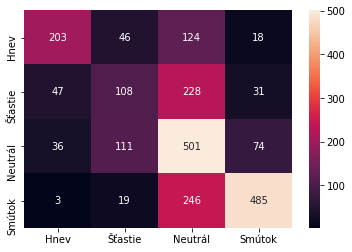

In [19]:
seaborn.heatmap(final, xticklabels=['Hnev','Šťastie','Neutrál','Smútok'], yticklabels=['Hnev','Šťastie','Neutrál','Smútok'],annot=True, fmt="d")

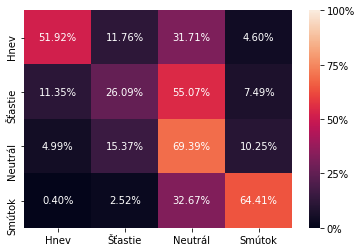

In [20]:
ax = seaborn.heatmap(percentage_matrix, xticklabels=['Hnev','Šťastie','Neutrál','Smútok'], yticklabels=['Hnev','Šťastie','Neutrál','Smútok'],vmin=0, vmax=1, annot=True, fmt=".2%")
cbar = ax.collections[0].colorbar.set_ticks([0, .25, .5, .75, 1])
cbar = ax.collections[0].colorbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])